# HW1 Applied ML - Omer Shadmi 327722575

## Question 1

### Getting Ready

In [134]:
# Importing some libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [39]:
# Define the path to the Parquet file
file_path = r"C:\Users\shadm\Documents\data\data1.parquet"

# Read the Parquet file
df1 = pd.read_parquet(file_path)

In [40]:
# Set the x column and the y column
x = df1.iloc[:, 0].values
y = df1.iloc[:, 1].values

In [41]:
# Let's see how the data1 looks like
df1.head()

,x,y
0,12.209516,36.021575
1,62.623142,162.746072
2,-14.712353,166.459738
3,130.624579,551.308062
4,121.652246,208.207596


In [47]:
df1.shape

(103, 2)

We're now ready to start Question 1. 

**Model Choosing:**
We choose to use Deming Regression in this question. In this question, we have our two variables, x and y - measured with error.
Therefore, we choose to use a Deming model, which is a technique for this exact situation, unlike simple linear regression, that assumes error only in the response variable, y. 

**Assamptions:**
1. By the description of the task, we assume that the variance of the x column is half the variance of the y column.
   Thus, we set the ratio between the variances, lambda, to be 0.5.
2. We assume linear correlation: y = a*x+b.
3. We assume that the variances of both of the variables are normally distributed.

### Outliers

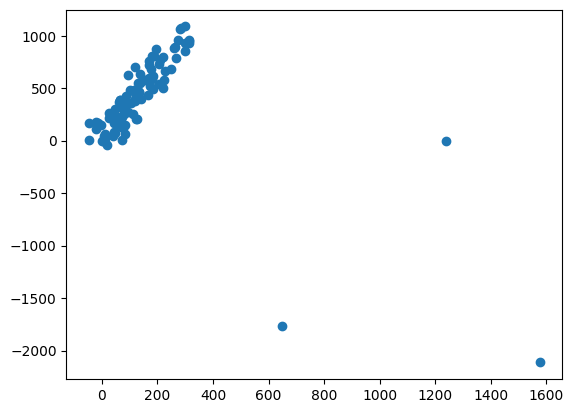

In [44]:
# Scattering the data to get a general feel
plt.scatter(x, y);

We see that we have few dramatic outliers we need to remove.

In [54]:
# A function to find and drop the ouliers of the data

def drop_outliers_IQR(df):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    
    # Calculate the IQR
    IQR = q3 - q1
    
    # Define a mask to filter out outliers
    mask = ~((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR)))
    
    # Apply the mask and drop NaN values
    outliers_dropped = df[mask].dropna().reset_index(drop=True)
    
    return outliers_dropped

In [77]:
# Get rid of the outliers in our data
df1 = drop_outliers_IQR(df1)

# Updating x and y
x = df1.iloc[:, 0].values
y = df1.iloc[:, 1].values

In [76]:
df1.shape

(100, 2)

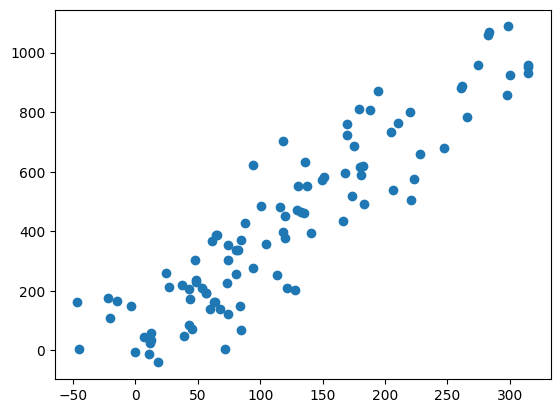

In [78]:
plt.scatter(x, y);

We dealt with the outliers, so we can start modeling the data. 
First, we are gonna do the simple linear regression.

### Simple Linear Regression

In [62]:
# Simple Linear Regression for Comparison
x_const = sm.add_constant(x)
ols_model = sm.OLS(y, x_const).fit()
y_pred_ols = ols_model.predict(x_const)

# The simple linear regression params
ols_intercept, ols_slope = ols_model.params
print(f"OLS Regression: Intercept = {ols_intercept}, Slope = {ols_slope}")

OLS Regression: Intercept = 70.02365496350102, Slope = 2.973585048126178


### Deming Regression

Now we are moving towards our new model, the Deming Regression model.
Let's implement it. 

* We remember our assumptions:
1. By the description of the task, we assume that the variance of the x column is half the variance of the y column.
   Thus, we set the ratio between the variances, lambda, to be 0.5.
2. We assume that the variances of both of the variables are normally distributed.

In [63]:
# Deming Regression function, note that we use the fact that the ratio between the variances is 0.5

def deming_regression(x, y, ratio=0.5):
    # Center the data
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    # Calculate the sample covariance and variances
    n = len(x)
    s_xx = np.sum(x_centered**2) / (n - 1)  # Sample variance of x
    s_yy = np.sum(y_centered**2) / (n - 1)  # Sample variance of y
    s_xy = np.sum(x_centered * y_centered) / (n - 1)  # Sample covariance between x and y
    
    # Calculate the slope (beta)
    beta = (s_yy - ratio * s_xx + np.sqrt((s_yy - ratio * s_xx)**2 + 4 * ratio * s_xy**2)) / (2 * s_xy)
    
    # Calculate the intercept (alpha)
    alpha = y_mean - beta * x_mean
    
    return alpha, beta

In [64]:
# Modeling our data
alpha, beta = deming_regression(x, y, ratio=0.5)

# The deming regression model params
print(f'Deming: Intercept(alpha) = {alpha}, Slope(beta) = {beta}')

Deming: Intercept(alpha) = 2.7710710616919414, Slope(beta) = 3.531184769244604


### Comparison between Simple and Deming regression

We wanna compare between the two different models we've used, we will do it using a graph.

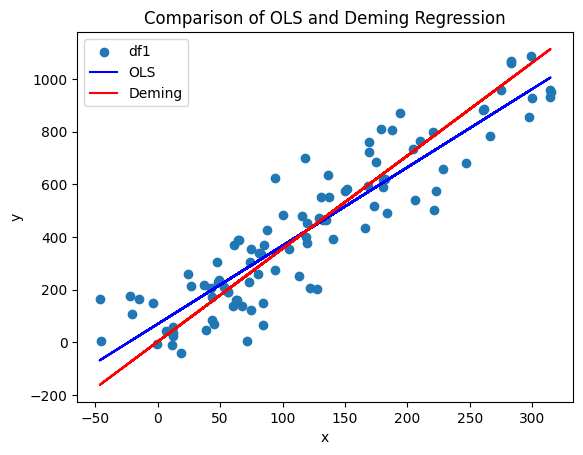

In [66]:
# Visualisation of the comparison between OLS (simple linear regression) and Deming Regression

plt.scatter(x, y, label='df1')
plt.plot(x, y_pred_ols, label='OLS', color='blue')
plt.plot(x, alpha + beta * x, label='Deming', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of OLS and Deming Regression')
plt.show()

In conclusion: The Deming Regression model did a pretty good job!

***

## Question 2

### Getting Ready

In [118]:
# Define the path to the Parquet file
file_path = r"C:\Users\shadm\Documents\data\data2.parquet"

# Read the Parquet file
df2 = pd.read_parquet(file_path)

In [119]:
# Set the x column and the y column
x = df2.iloc[:, 0].values
y = df2.iloc[:, 1].values

In [120]:
df2.head()

,x,y
0,0.00000,10.248357
1,0.10101,9.974390
2,0.20202,10.490277
3,0.30303,11.143792
4,0.40404,10.037640


In [121]:
df2.shape

(100, 2)

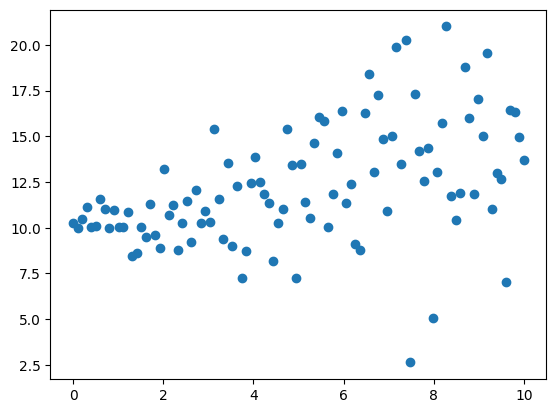

In [73]:
# Scattering the data to get a general feel
plt.scatter(x, y);

We have some outliers here, let's see how the different models (simple linear and quantile regression) are coping with them. 

### Simple Linear Regression and Residual Analysis

In [122]:
# OLS Regression
X = sm.add_constant(x)
linear_model = sm.OLS(y, X).fit()
y_pred_linear = linear_model.predict(X)

# Print the summary of the linear regression model
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     26.28
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           1.48e-06
Time:                        12:28:26   Log-Likelihood:                -248.23
No. Observations:                 100   AIC:                             500.5
Df Residuals:                      98   BIC:                             505.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6752      0.581     16.660      0.0

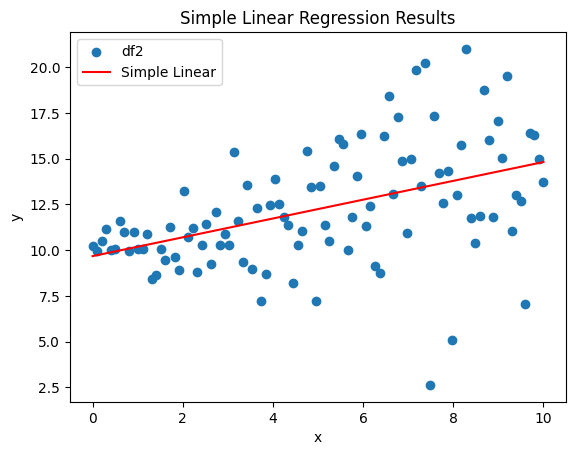

In [123]:
# Visualise the Simple Linear Regression results
plt.scatter(x, y, label='df2')
plt.plot(x, y_pred_linear, label='Simple Linear', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Simple Linear Regression Results')
plt.show()

We are gonna take a look at the residuals of the simple linear model, and see if they match the assumptions of the linear regression.

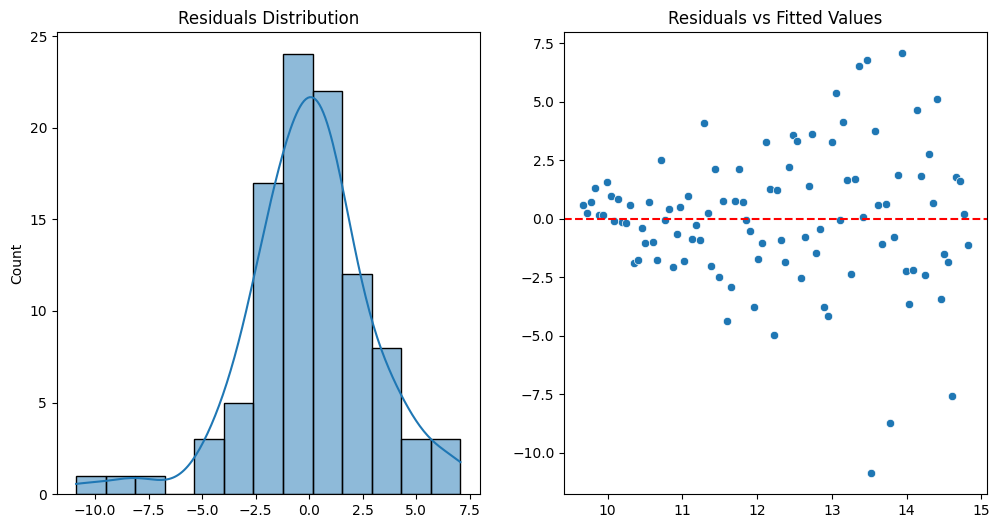

In [124]:
# Get the residuals
residuals = linear_model.resid

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')

plt.subplot(1, 2, 2)
sns.scatterplot(x=linear_model.fittedvalues, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')

plt.show()

**Conclusions:**
* *Normality:* We see that the residuals do follow some kind of a normal distribution, which matches our linear regression assumption.
* *Constant Variance:* On the other hand, another linear regression assumption doesn't exist here. We assume that the residuals of our linear regression spread out evenly over any fitted value, that is, xonstant variance of the residuals. In our case, we can see some pattern in the variance of the residuals, the plot shows a funnel shape (residuals spreading out as fitted values increase),  meaning that the variance of the residuals is not constant.

And that's exactly where quantile regression comes to our aid!
Quantile regression could be beneficial in this case as it does not assume constant variance of the residuals.

### Quantile Regression

In [125]:
# Quantile Regression
quantiles = [0.05, 0.5, 0.95]
quantile_models = []

for q in quantiles:
    quantile_model = smf.quantreg('y ~ x', df2).fit(q=q)
    quantile_models.append(quantile_model)
    print(f'\nQuantile: {q}')
    print(quantile_model.summary())


Quantile: 0.05
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:              0.04929
Model:                       QuantReg   Bandwidth:                       4.316
Method:                 Least Squares   Sparsity:                        16.25
Date:                Thu, 20 Jun 2024   No. Observations:                  100
Time:                        12:29:01   Df Residuals:                       98
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1829      0.781     11.759      0.000       7.633      10.733
x             -0.3945      0.122     -3.229      0.002      -0.637      -0.152

Quantile: 0.5
                         QuantReg Regression Results                          
Dep. Variable:       

We compare the quantile regression and the linear regression using a plot.

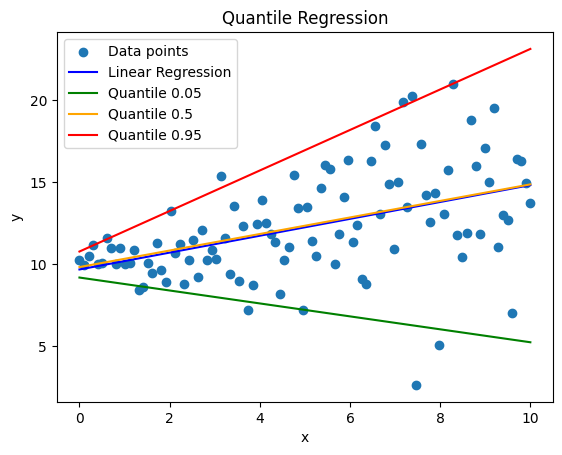

In [130]:
# Quantile Regression results compared to linear regression

X = sm.add_constant(df2['x'])
colors = ['green', 'orange', 'red']

# Plot df2 points
plt.scatter(df2['x'], df2['y'], label='Data points')

# Plot the linear regression result
plt.plot(df2['x'], y_pred_linear, color='blue', label='Linear Regression')

# Plot the quantile regression results
for i, q in enumerate(quantiles):
    plt.plot(df2['x'], quantile_models[i].predict(X), color=colors[i], label=f'Quantile {q}')
    
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Quantile Regression')
plt.show()

### Quantile Regression Description

**How it works:** Quantile regression, is a type of regression analysis used in statistics. Unlike ordinary least squares (OLS) regression, which estimates the conditional mean of the response variable, quantile regression estimates the conditional median or other quantiles of the response variable. This makes it particularly useful for understanding the impact of predictors on different points of the distribution of the response variable.

**What it is aiming to minimize:** Quantile regression aims to minimize the sum of weighted absolute residuals, where the weights are determined by the quantile being estimated.
For example: For quantile=0.5 (the median), the regression aims to minimize the sum of absolute residuals, making the median regression line such that 50% of the data points lie above and 50% lie below it. Thus, quantile regression offers a comprehensive view of the relationships between variables across different points of the distribution, not just the central tendency, by minimizing the appropriately weighted absolute residuals for the specified quantiles.


**When to use it:**
1. When we have non-constant variance of the residuals: OLS assumes constant variance, but quantile regression doesn't.
2. When we have non-normal error distribution: OLS assumes normal distribution of the residuals, but quantile regression doesn't.
3. When we have outliers: In the presence of outliers, OLS regression can be heavily influenced, but quantile regression is less sensitive to these.

**Conclusions:**
* In our case, it was adequate to use quantile regression over simple linear regression because we had non-constant variance of the residuals, and few outliers.
* However, the quantile regression with quantile=0.5(the median), did similar job to the simple linear regression. So we can conclude that the non-constant variance and the outliers in our data weren't very critical, and the linear regression was just fine.

***

## Question 3

### Getting Ready

In [191]:
# Define the path to the Parquet file
file_path = r"C:\Users\shadm\Documents\data\data3.parquet"

# Read the Parquet file
df3 = pd.read_parquet(file_path)

In [192]:
df3.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [193]:
df3.shape

(506, 14)

### Outliers

In [194]:
# Check the outliers situation
df3_no_outliers = drop_outliers_IQR(df3)
df3_no_outliers.shape

(268, 14)

We have too many outliers, so we can't throw them away. And as mentioned in the description of this task, only one of the datasets may have critical outliers, and we've already found that this is df1 :). 

Now we're ready to start Ridge Regression

### Ridge Regression 

We are looking for the best reglizer of the coefficient of the ridge regression. We have our response variable "label", and all the other, feature variables. 

In [195]:
# Separate the features and the response variable
X = df3.drop(columns=['label'])
y = df3['label']

* Our task it to search over all possible values of 𝛂. For each to perform cross validation using the RepeatedKFold function with 10 splits and 3 repeats. Then find the 𝛂 that minimizes the mean absolute error using grid search. We need to look for a function that incorporates the cross validation in the search).
* We have found the function "GridSearchCV" for this exact purpose. 

In [196]:
# Define the model
model = Ridge()

# Define the alphas
param_grid = {'alpha': [i * 0.01 for i in range(101)]}

# Set the cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Use GridSearchCV to search for the best alpha
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                   0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13,
                                   0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2,
                                   0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27,
                                   0.28, 0.29, ...]},
             scoring='neg_mean_absolute_error')

**Note:** The 'GridSearchCV' function aims to maximize the metric it gets. But we want to minimize the MAE, so we will give it the negative MAE, because the absolute value of maximum of the negative MAE is equivalent to absolute value of the minimum of the positive MAE.

### Conclusions

So now in order to find the minimal MAE and the corresponding alpha, we will take the alpha that optimize our function, and the negative of the optimum of our function. 

In [197]:
# Get the best MAE score and the corresponding alpha
best_mae = -grid_search.best_score_
best_alpha = grid_search.best_params_['alpha']

print(f"Best MAE: {best_mae}")
print(f"Best alpha: {best_alpha}")

Best MAE: 3.3788297594275507
Best alpha: 0.51


**The best alpha value is:** 0.51

**The best MAE value is:** 3.38

***

*The End!*